<a href="https://colab.research.google.com/github/JaccoVeldscholten/SmartDispenser/blob/main/BAVA_TVOC_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
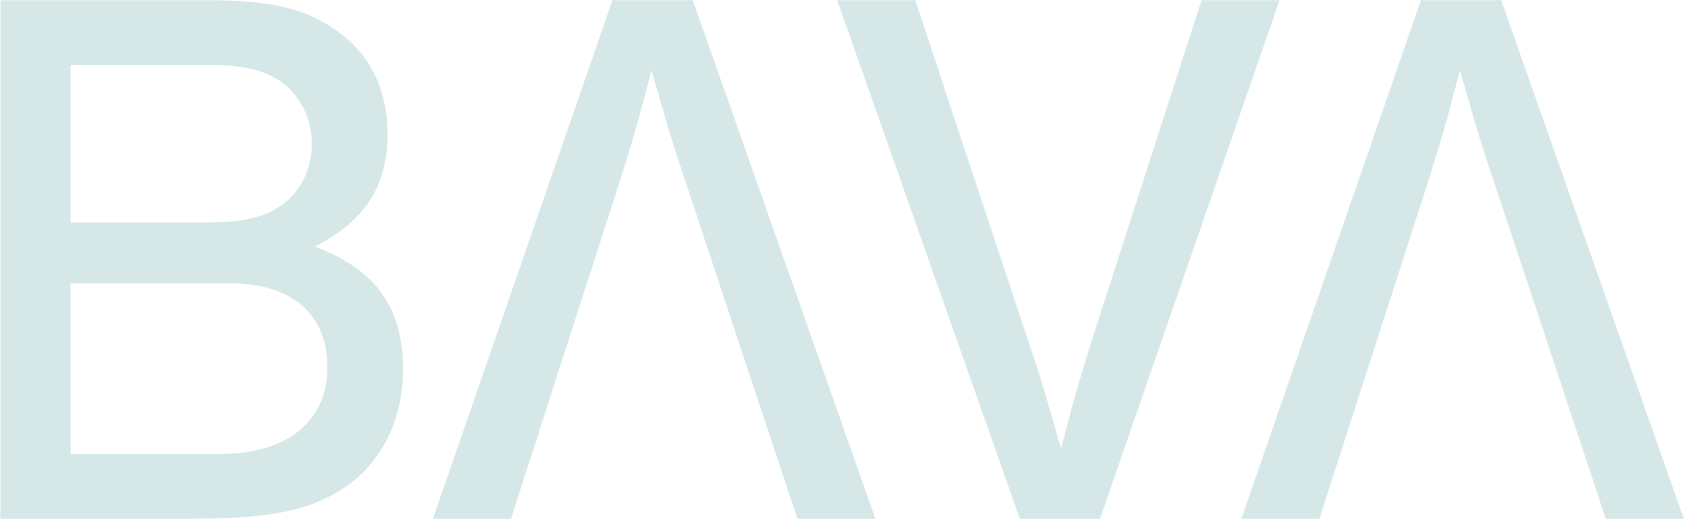
</div>

**API Validation & Prediction** <br>
This document will be validate the gathered API Data and will is able to being used for predictions and analyses

***Temperature Prediction*** <br>
To start off Machine Learning is being used to predict the temperature of the certain amount of days in the toilet. By using basic regression model (linear) its possible to predict the temperature based on the API data thats being generated by the device.

# Imports <br>
In the first stage of the notebook all imports should be made for running the code later on in the notebook

In [ ]:
import urllib.request
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
import datetime

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

# Disable copy warn
pd.options.mode.chained_assignment = None  # default='warn'

2.7.0


# Fetching API <br>
First gather the API Data from the URL. After that print the first elements of the fetched data

In [ ]:
with urllib.request.urlopen("https://us-central1-bava-solutions.cloudfunctions.net/getAllDeviceData") as url:
    data = json.loads(url.read().decode())

In [ ]:
df = pd.DataFrame(data)
df.tail()
# df['timestamp'][0]

,waterlevel,batterylevel,hum,pressure,tvoc_co2,occupied,mac,timestamp,tvoc_ppm,temp,altitude
490,100,100,45,100282,166,False,4C:EB:D6:74:46:C4,"{'_seconds': 1638267652, '_nanoseconds': 48000...",3,19,90
491,100,100,45,100294,169,False,4C:EB:D6:74:46:C4,"{'_seconds': 1638267950, '_nanoseconds': 30800...",3,19,89
492,100,100,44,100285,153,False,4C:EB:D6:74:46:C4,"{'_seconds': 1638268576, '_nanoseconds': 13000...",1,19,90
493,100,100,45,100332,165,False,4C:EB:D6:74:46:C4,"{'_seconds': 1638272021, '_nanoseconds': 21300...",3,18,86
494,100,100,45,100338,147,False,4C:EB:D6:74:46:C4,"{'_seconds': 1638272643, '_nanoseconds': 62800...",0,18,85


# Plotting the data

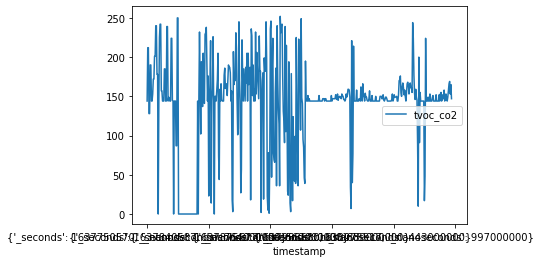

In [ ]:
df.plot(x='timestamp', y='tvoc_co2')

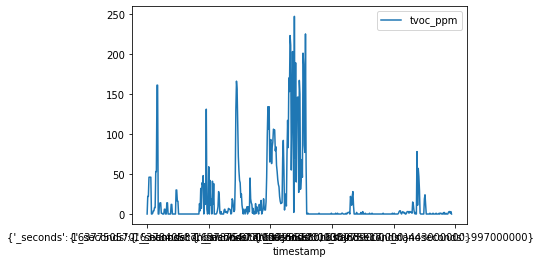

In [ ]:
# Reading TVOC
df = pd.DataFrame(data)
df.plot(x='timestamp', y='tvoc_ppm')

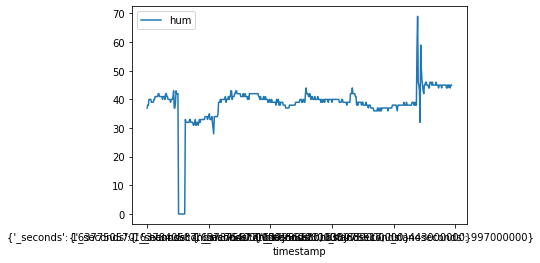

In [ ]:
# Reading humidty
df.plot(x='timestamp', y='hum')

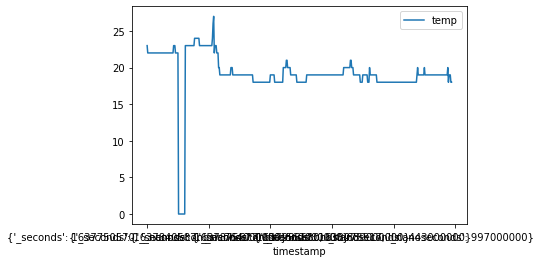

In [ ]:
# Reading temperature
df.plot(x='timestamp', y='temp')

# The numbers mason <br>
The numbers mason what do they mean?

In [ ]:
# Getting all triggers by occupation
triggerd_by_occupation = df[df['occupied']==1]
triggerd_by_occupation.count()['occupied']

46

In [ ]:
# Getting all triggers by timer
triggerd_by_timer = df[df['occupied']==0]
triggerd_by_timer.count()['occupied']

449

# Predictions <br>
**Predictions based on Machine learning data**<br> 
First prediction is determining what the temperature might be in a few days.


In [ ]:
# Tensorflow
np.set_printoptions(precision=3, suppress=True)

#Clean the data. Drop any columns with missing values or null values.

dropping timestamp and mac because they are categorical and irrelevant.

dropping batterylevel and waterlevel because they all have same data.

In [ ]:
dataset = df.copy()
dataset.isna().sum()

dataset.dropna()
cleaned_dataset = dataset.drop(['mac', 'batterylevel', 'waterlevel', 'occupied'], axis=1)

temp = cleaned_dataset

for i in range(len(cleaned_dataset['timestamp'])):
  cleaned_dataset['timestamp'][i] = datetime.datetime.utcfromtimestamp((cleaned_dataset['timestamp'][i]['_seconds']) ).strftime('%Y-%m-%d')

cleaned_dataset.index = pd.to_datetime(cleaned_dataset['timestamp'])
cleaned_dataset = cleaned_dataset[cleaned_dataset['tvoc_ppm'] != 0]
cleaned_dataset = cleaned_dataset.drop(['timestamp'], axis=1)
cleaned_dataset


,hum,pressure,tvoc_co2,tvoc_ppm,temp,altitude
timestamp,,,,,,
2021-11-24,38,102241,212,22,22,-79
2021-11-24,38,102240,212,22,22,-78
2021-11-24,40,102221,128,46,22,-78
2021-11-24,40,102229,128,46,22,-77
2021-11-24,40,102216,190,46,22,-76
...,...,...,...,...,...,...
2021-11-30,45,100283,158,2,18,91
2021-11-30,45,100282,166,3,19,90
2021-11-30,45,100294,169,3,19,89


#Splitting for regression using Tensorflow

In [ ]:

train_data = cleaned_dataset.sample(frac=0.5, random_state=0)

test_data = cleaned_dataset.sample(frac=0.2, random_state=0)

# test_data

# cleaned_dataset = cleaned_dataset.drop(['timestamp'], axis=1)

# train_data, test_data = np.split(cleaned_dataset, [int(.3 *len(data))])

train_data
print(len(test_data), len(train_data), len(cleaned_dataset))

# Y = cleaned_dataset['temp']
# x = cleaned_dataset.loc[:, cleaned_dataset.columns != 'temp']

52 129 258


#Split attributes and labels apart

In [ ]:
train_features = cleaned_dataset.copy()
test_features = cleaned_dataset.copy()

train_labels = train_features.pop('temp')
test_labels = test_features.pop('temp')



train_labels

train_data = train_data.drop(['temp'], axis=1)
test_data = test_data.drop(['temp'], axis=1)

print(test_data)

# train_dataset_timeseries = keras.preprocessing.timeseries_dataset_from_array(train_data, train_labels, sequence_length=len(train_data))
# TimeSeries

            hum  pressure  tvoc_co2  tvoc_ppm  altitude
timestamp                                              
2021-11-27   39     98514       158         2       245
2021-11-25   40    100752       170         3        49
2021-11-28   38     99535       165         3       155
2021-11-25   41    100731       182         5        51
2021-11-25   40    100715         1       134        53
2021-11-26   37     98362        24        83       258
2021-11-24   40    102202       172         4       -75
2021-11-28   69     99631        88        11       147
2021-11-26   39     98232        39        77       269
2021-11-25   39    100592       176        70        63
2021-11-27   39     98458       153         1       250
2021-11-26   38     98345        93       109       260
2021-11-25   39    100624        36        22        61
2021-11-25   33    100986       141        38        29
2021-11-28   38     99542       164         3       155
2021-11-26   42     98239       195       225   

In [ ]:
train_stat = train_data.describe().transpose()[['mean', 'std']]
train_stat

,mean,std
hum,39.984496,4.023339
pressure,100204.108527,1265.452206
tvoc_co2,152.023256,62.408366
tvoc_ppm,37.674419,51.931018
altitude,97.093023,110.661607


#Normalization
***Normalizing is helpful to bound data between the range from 0 to 1***

In [ ]:
def normalize(row):
  # t = row['timestamp']
  

  answer = (row - train_stat['mean']) / train_stat['std']
  print(row, answer)
  # answer['timestamp'] = t
  
  return answer

normed_train = normalize(train_data)
normed_test = normalize(test_data)

print(normed_test)



normed_train = np.asarray(normed_train).astype(np.float32)
normed_test = np.asarray(normed_test).astype(np.float32)

# normed_train
# normed_test
train_labels

            hum  pressure  tvoc_co2  tvoc_ppm  altitude
timestamp                                              
2021-11-27   39     98514       158         2       245
2021-11-25   40    100752       170         3        49
2021-11-28   38     99535       165         3       155
2021-11-25   41    100731       182         5        51
2021-11-25   40    100715         1       134        53
...         ...       ...       ...       ...       ...
2021-11-26   39     98275       223        27       265
2021-11-25   33    100961        14        19        31
2021-11-28   38     99529       166         3       156
2021-11-30   45    100283       158         2        91
2021-11-25   40    100712        64        65        53

[129 rows x 5 columns]                  hum  pressure  tvoc_co2  tvoc_ppm  altitude
timestamp                                                   
2021-11-27 -0.244696 -1.335577  0.095768 -0.686958  1.336570
2021-11-25  0.003853  0.432961  0.288050 -0.667701 -0.434595
2021

timestamp
2021-11-24    22
2021-11-24    22
2021-11-24    22
2021-11-24    22
2021-11-24    22
              ..
2021-11-30    18
2021-11-30    19
2021-11-30    19
2021-11-30    19
2021-11-30    18
Name: temp, Length: 258, dtype: int64

#Building the model using Tensorflow Keras

In [ ]:
# For building the model using function for in the future its better to create multiple models
def create_model():
  model = keras.Sequential([
      layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_data.keys())]),
      layers.Dense(1)
  ])

  optimiser = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimiser, metrics=['mae', 'mse'])

  return model

In [ ]:
model = create_model()

#Insights of the model

In [ ]:
model.summary() # Overview of the created model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_block = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)                                     # Add auto stop incase the loss is less enough.
full_model = model.fit(normed_train, train_labels, epochs=10000, validation_split=0.2, callbacks=[early_block])   # Actual model training

Epoch 1/10000
4/4 [==============================] - 1s 67ms/step - loss: 429.1702 - mae: 20.6314 - mse: 429.1702 - val_loss: 322.5802 - val_mae: 17.9543 - val_mse: 322.5802
Epoch 2/10000
4/4 [==============================] - 0s 10ms/step - loss: 422.0151 - mae: 20.4575 - mse: 422.0151 - val_loss: 318.3947 - val_mae: 17.8375 - val_mse: 318.3947
Epoch 3/10000
4/4 [==============================] - 0s 10ms/step - loss: 417.0378 - mae: 20.3354 - mse: 417.0378 - val_loss: 314.6258 - val_mae: 17.7315 - val_mse: 314.6258
Epoch 4/10000
4/4 [==============================] - 0s 10ms/step - loss: 412.5300 - mae: 20.2242 - mse: 412.5300 - val_loss: 311.3665 - val_mae: 17.6390 - val_mse: 311.3665
Epoch 5/10000
4/4 [==============================] - 0s 10ms/step - loss: 408.2493 - mae: 20.1172 - mse: 408.2493 - val_loss: 308.1005 - val_mae: 17.5459 - val_mse: 308.1005
Epoch 6/10000
4/4 [==============================] - 0s 11ms/step - loss: 404.2848 - mae: 20.0178 - mse: 404.2848 - val_loss: 305.

# Model training validation
How well did the model trained? How is the loss?


In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot() # Plot the loss

## Model Testing


In [ ]:
# Tesing the Model based on values from training X = Time , Y = Predicted temperature
testmodel = pd.DataFrame(model.predict(normed_test))
testmodel.plot()

In [ ]:
# Predict what the temperature will be after x amount of days
howmany = 90 # 10 days
answer = model.predict([normed_test[0:(howmany % len(normed_test))]])
print(f"The temperature would be {answer.mean()} degrees after {howmany}")